In [1]:
try:
    import gdal
except:
    from osgeo import gdal
from gdalconst import *
import numpy as np
from glob import glob
from os import path as osp
import os, subprocess
import matplotlib.pyplot as plt

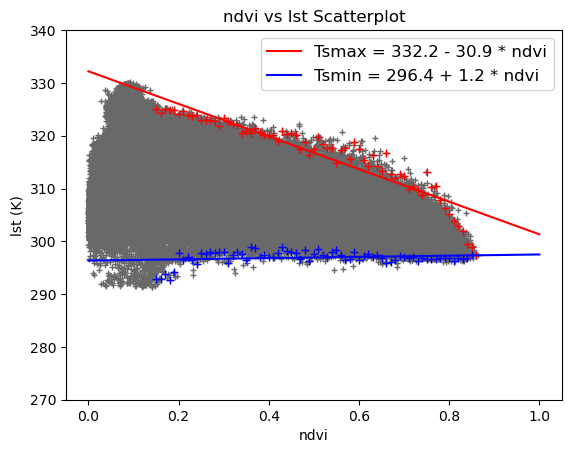

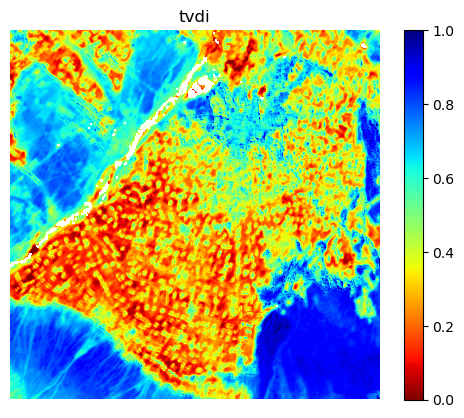

In [5]:
# 获取lst、ndvi数据
def get_data(file_ndvi,file_lst):
    ndvi_tif=gdal.Open(file_ndvi,GA_ReadOnly)
    lst_tif=gdal.Open(file_lst,GA_ReadOnly)
    ndvi_band=ndvi_tif.GetRasterBand(1)
    ndvi=ndvi_band.ReadAsArray()
    lst_band=lst_tif.GetRasterBand(1)
    lst=lst_band.ReadAsArray()    
    return ndvi,lst

# 获取投影等信息，用于保存TVDI结果
def get_info(file_ndvi):
    ndvi_tif=gdal.Open(file_ndvi,GA_ReadOnly)
    ndvi_band=ndvi_tif.GetRasterBand(1)
    gt = ndvi_tif.GetGeoTransform()
    proj = ndvi_tif.GetProjectionRef()
    dtype = ndvi_band.DataType
    return gt,proj,dtype

# 计算lst的最小值（湿边）和最大值（干边）
def get_min_max(ndvi,lst):
    MiniList = []
    MaxList = []
    # 创建ndvi向量（0到1，间距为0.01）
    ndvi_vector = np.round(np.arange(0.01, 1.01, 0.01), 2)
    # 首先找到相同ndvi的lst值
    for val in ndvi_vector:
        lst_lst_val = []
        row, col = np.where((ndvi >= val-0.001) & (ndvi <= val+0.001))
        # 根据这些ndvi的位置，我们取温度值对应这些位置（行和列）
        for i in range(len(row)):
            if np.isfinite(lst[row[i], col[i]]):
                lst_lst_val += [lst[row[i], col[i]]]
            # 如果所需的ndvi有lst值，则计算最大值和最小值
        if lst_lst_val != []:
            lst_min_val = np.min(lst_lst_val)
            lst_max_val = np.max(lst_lst_val)
        else:
            lst_min_val = np.nan
            lst_max_val = np.nan
        # 找到的值被添加到MiniList和MaxList列表中
        MiniList += [lst_min_val]
        MaxList  += [lst_max_val]
    return MiniList,MaxList

def fit(MiniList,MaxList):
    ndvi_vector = np.round(np.arange(0.01, 1.01, 0.01), 2)
    MiniList_fin = []
    ndvi_fin = []
    for i, val in enumerate(MiniList):
        if np.isfinite(val):
            MiniList_fin += [val]
            ndvi_fin += [ndvi_vector[i]]
    MinPfit = np.polyfit(ndvi_fin[14:89], MiniList_fin[14:89], 1)
    MaxList_fin = []
    ndvi_fin = []
    for i, val in enumerate(MaxList):
        if np.isfinite(val):
            MaxList_fin += [val]
            ndvi_fin += [ndvi_vector[i]]
    MaxPfit = np.polyfit(ndvi_fin[14:89], MaxList_fin[14:89], 1)
    return MinPfit,MaxPfit

def plot_scatter(ndvi,lst,MiniList,MaxList,MinPfit,MaxPfit,scatter_file=None):
    ndvi_vector = np.round(np.arange(0.01, 1.01, 0.01), 2)
    a1, b1 = MaxPfit
    a2, b2 = MinPfit
    linhamax = [b1 + (a1 * 0), b1 + (a1 * 1)]
    linhamin = [b2 + (a2 * 0), b2 + (a2 * 1)]

    plt.plot(ndvi.ravel(), lst.ravel(), "+", color='dimgray', markersize=4)
    plt.plot(ndvi_vector[14:89], MiniList[14:89], '+', color='b')
    plt.plot(ndvi_vector[14:89], MaxList[14:89], '+', color='r')
    if a1>0:
        plt.plot([0, 1], linhamax, color='r', markersize=8,\
                         label=f"Tsmax = {'%.1f'% b1} + {'%.1f' % abs(a1)} * ndvi")
    else:
        
        plt.plot([0, 1], linhamax, color='r', markersize=8,\
                         label=f"Tsmax = {'%.1f'% b1} - {'%.1f' % abs(a1)} * ndvi")
    if a2>0:
        plt.plot([0, 1], linhamin, color='b', markersize=8,\
                         label=f"Tsmin = {'%.1f' % b2} + {'%.1f' % abs(a2)} * ndvi")
    else:
        plt.plot([0, 1], linhamin, color='b', markersize=8,\
                         label=f"Tsmin = {'%.1f' % b2} - {'%.1f' % abs(a2)} * ndvi")
    plt.legend(loc='upper right', fontsize=12)
    plt.ylim(top=340,bottom=270)
    plt.xlabel("ndvi")
    plt.ylabel("lst (K)")
    plt.title("ndvi vs lst Scatterplot")
    if scatter_file is not None:
        plt.savefig(scatter_file)
    plt.show()
    
def show_tvdi(tvdi,fig_file=None):
    plt.imshow(tvdi,cmap= 'jet_r',vmax=1,vmin = 0)
    plt.axis('off')
    plt.colorbar()
    plt.title("tvdi")
    if fig_file is not None:
        plt.savefig(fig_file)
    plt.show()
    
def compute_tvdi(ndvi,lst,MinPfit,MaxPfit):
    a1, b1 = MaxPfit
    a2, b2 = MinPfit

    Ts_max = b1 + (a1 * ndvi)
    Ts_min = b2 + (a2 * ndvi)

    TVDI = (lst - Ts_min) / (Ts_max - Ts_min)
    
    return TVDI

def save_tvdi(TVDI,gt,proj,dtype,file_out):
    fname_out   = file_out
    driver      = gdal.GetDriverByName('GTiff')
    data_type   = dtype
    dset_output = driver.Create(fname_out, TVDI.shape[1], TVDI.shape[0], 1, gdal.GDT_Float32)
    dset_output.SetGeoTransform(gt)
    dset_output.SetProjection(proj)
    dset_output.GetRasterBand(1).WriteArray(TVDI)
    dset_output.FlushCache()
    dset_output = None
    
def main(ndvi_file,lst_file,tvdi_file,scatter_file=None,fig_file=None):
    '''
    Parameters
    ----------
    ndvi_file : the file of ndvi

    lst_file : the file of lst

    tvdi_file : the file use to save tvdi

    scatter_file : the file use to save scatter

    fig_file : the file use to save the figure of tvdi
    '''
    # 获取ndvi和lst数据
    ndvi,lst=get_data(ndvi_file,lst_file)
    ndvi[ndvi<0]=np.nan
    lst[lst<250]=np.nan
    # 获取lst的最小值（湿边）和最大值（干边）
    MiniList,MaxList=get_min_max(ndvi,lst)
    # 计算tvdi,并保存
    MinPfit,MaxPfit=fit(MiniList,MaxList)
    tvdi=compute_tvdi(ndvi,lst,MinPfit,MaxPfit)
    gt,proj,dtype=get_info(ndvi_file)
    save_tvdi(tvdi,gt,proj,dtype,tvdi_file)
    # 显示散点图
    plot_scatter(ndvi,lst,MiniList,MaxList,MinPfit,MaxPfit,scatter_file)
    # 展示tvdi结果
    show_tvdi(tvdi,fig_file)

if __name__ == '__main__':
    ndvi_file=r'data/ndvi.tif'
    lst_file=r'data/lst.tif'
    tvdi_file=r'tvdi.tif'

    main(ndvi_file,lst_file,tvdi_file)